In [1]:
# ml_tech_managers.py
"""
Análisis de Equidad de Género en Cargos Gerenciales y Salarios - Sector Tech
============================================================================

OBJETIVO DE INVESTIGACIÓN:
- ¿Se da la misma importancia a las mujeres en cargos gerenciales?
- ¿Existe brecha salarial de género en el sector tech?
- ¿Qué factores influyen en la representación femenina en management?

Este módulo analiza:
1. Probabilidad de que una mujer alcance posiciones gerenciales
2. Brecha salarial entre hombres y mujeres
3. Factores que favorecen/limitan la equidad de género
4. Predicciones y recomendaciones para mejorar la equidad

Autor: [Tu nombre]
Fecha: [Fecha actual]
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix


In [2]:
# =========================
# 1. GENERAR DATASET
# =========================
def generate_realistic_gender_dataset(n_samples=1000):
    np.random.seed(42)
    is_female_employee = np.random.choice([0, 1], n_samples, p=[0.72, 0.28])

    companies = ["TechGlobal","DataCorp","CloudSystems","AIInnovate","CodeFactory",
                 "DigitalFlow","TechSolutions","InnovateLab","DataMining","CloudFirst"]
    countries = ["USA","Canada","Mexico","Chile","Spain","Colombia","Argentina"]
    departments = ["Engineering","Data Science","DevOps","Product","AI Research"]
    company_sizes = ["Startup","Small","Medium","Large","Enterprise"]
    education_levels = ["Bachelor","Master","PhD","Bootcamp"]

    df = pd.DataFrame({
        "employee_id": range(1, n_samples + 1),
        "company": np.random.choice(companies, n_samples),
        "country": np.random.choice(countries, n_samples,
                                    p=[0.35,0.20,0.15,0.12,0.08,0.06,0.04]),
        "department": np.random.choice(departments, n_samples),
        "company_size": np.random.choice(company_sizes, n_samples,
                                         p=[0.15,0.25,0.30,0.25,0.05]),
        "education": np.random.choice(education_levels, n_samples,
                                      p=[0.40,0.35,0.20,0.05]),
        "Genero": np.where(is_female_employee==1,"Mujer","Hombre"),
        "is_female": is_female_employee
    })

    # Variables numéricas
    df["years_experience"] = np.clip(np.round(np.random.gamma(3, 2.5, n_samples)), 1, 25).astype(int)
    df["age"] = np.clip(24 + df["years_experience"] + np.random.normal(0, 2, n_samples), 24, 60).astype(int)
    df["team_size"] = np.clip(np.round(np.random.exponential(4, n_samples)), 1, 30).astype(int)

    # Sesgo en gerencia
    prob_manager = 0.18 - 0.08 * df["is_female"]
    prob_manager = np.clip(prob_manager, 0.05, 0.25)
    df["Cargo_Gerencia"] = np.random.binomial(1, prob_manager)

    # Salarios
    base_salary = 35000 + df["years_experience"]*1200 + df["team_size"]*300
    gender_penalty = np.where(df["Genero"]=="Mujer", np.random.uniform(0.85,0.95, n_samples), 1.0)
    manager_bonus = np.where(df["Cargo_Gerencia"]==1, np.random.uniform(1.3,1.6, n_samples), 1.0)

    df["Salario"] = (base_salary * gender_penalty * manager_bonus
                     + np.random.normal(0, 3000, n_samples)).astype(int)

    return df

# Generar dataset
df = generate_realistic_gender_dataset(1000)



--- Distribución de género ---
Genero
Hombre    72.8
Mujer     27.2
Name: proportion, dtype: float64

--- Salario promedio por género ---
Genero
Hombre    48252.81
Mujer     42108.96
Name: Salario, dtype: float64

--- % de mujeres en cargos de gerencia ---
Genero
Hombre    79.86
Mujer     20.14
Name: proportion, dtype: float64


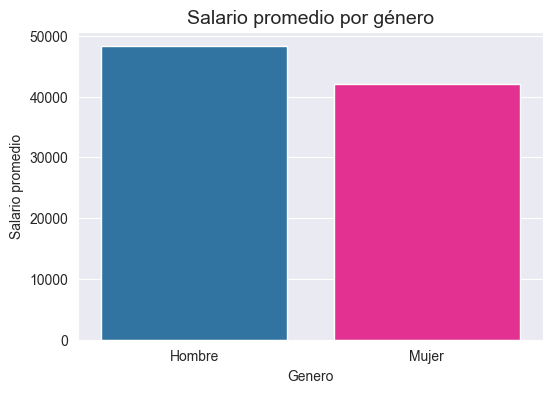

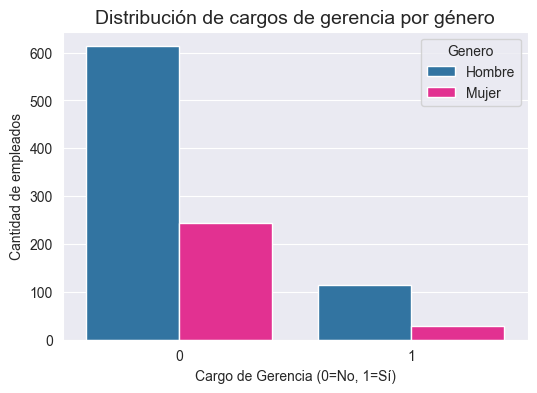

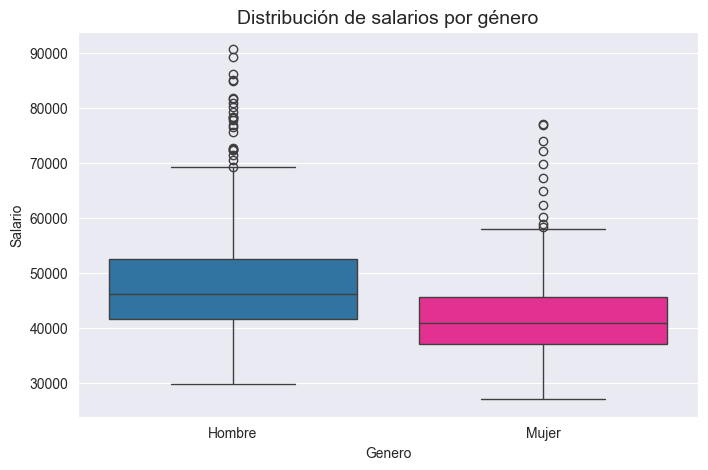

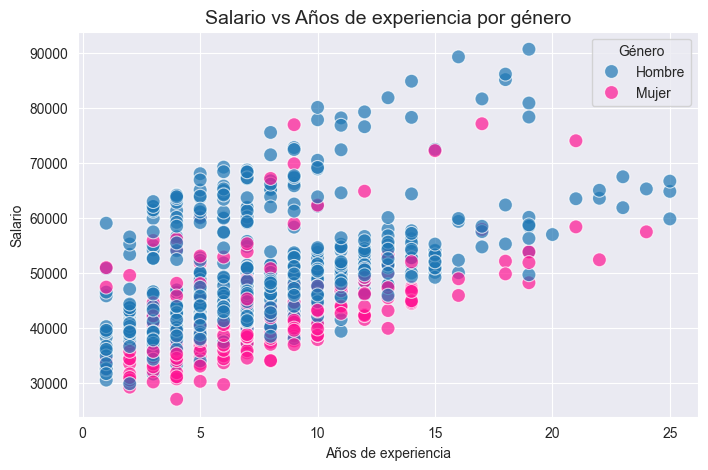

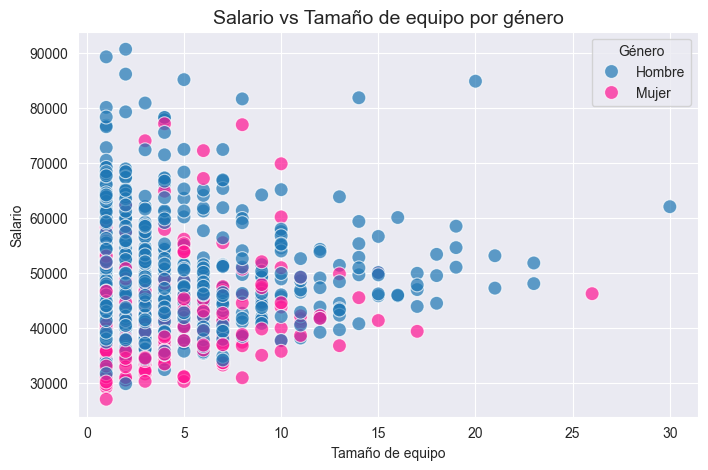

In [3]:
# =========================
# 2. ANÁLISIS EXPLORATORIO
# =========================
print("\n--- Distribución de género ---")
print((df["Genero"].value_counts(normalize=True)*100).round(2))

print("\n--- Salario promedio por género ---")
print(df.groupby("Genero")["Salario"].mean().round(2))

print("\n--- % de mujeres en cargos de gerencia ---")
print((df[df["Cargo_Gerencia"]==1]["Genero"].value_counts(normalize=True)*100).round(2))

# =========================
# 3. VISUALIZACIONES
# =========================
colores_vivos = ["#1f77b4", "#ff1493"]  # azul vivo y fucsia

# Salario promedio por género
plt.figure(figsize=(6,4))
sns.barplot(x="Genero", y="Salario", data=df, hue="Genero", palette=colores_vivos, legend=False, errorbar=None)
plt.title("Salario promedio por género", fontsize=14)
plt.ylabel("Salario promedio")
plt.show()

# Distribución de cargos de gerencia por género
plt.figure(figsize=(6,4))
sns.countplot(x="Cargo_Gerencia", hue="Genero", data=df, palette=colores_vivos)
plt.title("Distribución de cargos de gerencia por género", fontsize=14)
plt.xlabel("Cargo de Gerencia (0=No, 1=Sí)")
plt.ylabel("Cantidad de empleados")
plt.show()

# Boxplot de salarios por género
plt.figure(figsize=(8,5))
sns.boxplot(
    x="Genero",
    y="Salario",
    data=df,
    hue="Genero",           # asignar x como hue
    palette=colores_vivos,
    legend=False             # oculta la leyenda repetida
)

plt.title("Distribución de salarios por género", fontsize=14)
plt.ylabel("Salario")
plt.show()

# Scatter: Salario vs Experiencia
plt.figure(figsize=(8,5))
sns.scatterplot(x="years_experience", y="Salario", hue="Genero", data=df, palette=colores_vivos, s=100, alpha=0.7)
plt.title("Salario vs Años de experiencia por género", fontsize=14)
plt.xlabel("Años de experiencia")
plt.ylabel("Salario")
plt.legend(title="Género")
plt.show()

# Scatter: Salario vs Tamaño de equipo
plt.figure(figsize=(8,5))
sns.scatterplot(x="team_size", y="Salario", hue="Genero", data=df, palette=colores_vivos, s=100, alpha=0.7)
plt.title("Salario vs Tamaño de equipo por género", fontsize=14)
plt.xlabel("Tamaño de equipo")
plt.ylabel("Salario")
plt.legend(title="Género")
plt.show()

In [4]:
# =========================
# 4. PIPELINE Y MODELOS PREDICTIVOS (con manejo de categorías desconocidas)
# =========================
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import pandas as pd

features = ["Genero","country","department","company_size","education","years_experience","age","team_size"]
X = df[features]
y_class = df["Cargo_Gerencia"]

categorical = ["Genero","country","department","company_size","education"]
numeric = ["years_experience","age","team_size"]

# Guardar categorías conocidas para cada columna
known_categories = {col: X[col].unique().tolist() for col in categorical}

# =========================
# Preprocesador con manejo de categorías desconocidas
# =========================
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical),
    ("num", StandardScaler(), numeric)
])

# =========================
# Train/test estratificado
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y_class, test_size=0.3, random_state=42, stratify=y_class
)

# --- Random Forest optimizado ---
rf_pipeline = ImbPipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", RandomForestClassifier(
        n_estimators=500,
        max_depth=3,
        min_samples_split=2,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=42
    ))
])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:,1]

# --- XGBoost con SMOTE + scale_pos_weight ---
scale_weight = len(y_class[y_class==0]) / len(y_class[y_class==1])
xgb_pipeline = ImbPipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", XGBClassifier(
        eval_metric="logloss",    # obligatorio en versiones recientes
        n_estimators=200,
        max_depth=3,
        learning_rate=0.1,
        scale_pos_weight=scale_weight,
        random_state=42
    ))
])
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
y_proba_xgb = xgb_pipeline.predict_proba(X_test)[:,1]

# =========================
# Función de predicción segura para nuevas categorías
# =========================
def safe_predict(pipeline, df_input):
    df = df_input.copy()

    # Reemplazar categorías desconocidas por "Other"
    for col in categorical:
        df[col] = df[col].apply(lambda x: x if x in known_categories[col] else "Other")

    # Asegurar que todas las columnas requeridas por el pipeline existan
    if hasattr(pipeline, "feature_names_in_"):
        for col in pipeline.feature_names_in_:
            if col not in df.columns:
                df[col] = 0
        df = df[pipeline.feature_names_in_]

    # Predicción
    pred = pipeline.predict(df)
    proba = pipeline.predict_proba(df)[:,1]

    # Convertir a JSON serializable
    results = [{"predicted_cargo_gerencia": str(p), "probability": float(pr)}
               for p, pr in zip(pred, proba)]
    return results


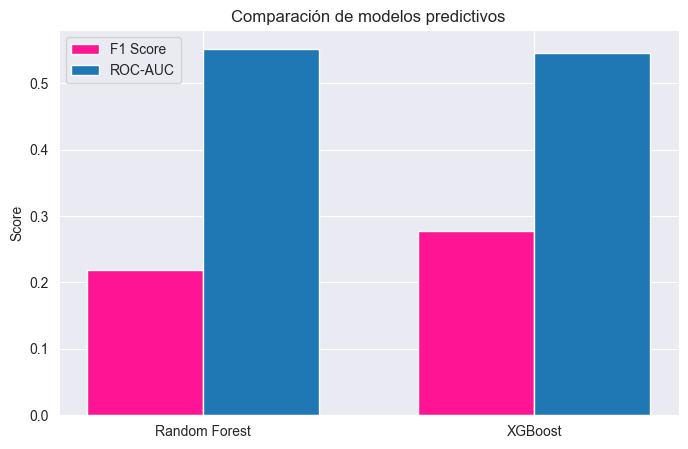

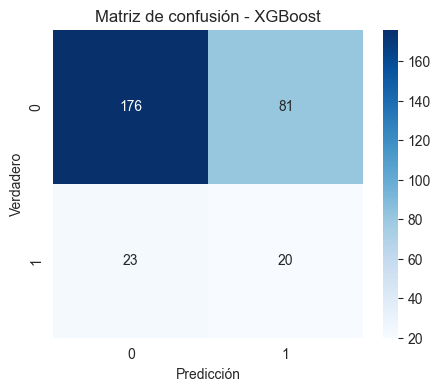

In [5]:
# =========================
# 5. COMPARACIÓN DE MODELOS
# =========================
model_names = ["Random Forest", "XGBoost"]
f1_scores = [f1_score(y_test, y_pred_rf), f1_score(y_test, y_pred_xgb)]
roc_auc_scores = [roc_auc_score(y_test, y_proba_rf), roc_auc_score(y_test, y_proba_xgb)]

plt.figure(figsize=(8,5))
bar_width = 0.35
index = np.arange(len(model_names))
plt.bar(index, f1_scores, bar_width, label='F1 Score', color="#ff1493")
plt.bar(index + bar_width, roc_auc_scores, bar_width, label='ROC-AUC', color="#1f77b4")
plt.xticks(index + bar_width/2, model_names)
plt.ylabel("Score")
plt.title("Comparación de modelos predictivos")
plt.legend()
plt.show()

# =========================
# 6. MATRIZ DE CONFUSIÓN DEL MEJOR MODELO
# =========================
# Elegimos XGBoost si tiene mayor F1
best_y_pred = y_pred_xgb
best_model_name = "XGBoost"

cm = confusion_matrix(y_test, best_y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Matriz de confusión - {best_model_name}")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.show()


In [6]:
df["Genero"].value_counts(normalize=True)*100
df.groupby("Genero")["Salario"].mean()
df[df["Cargo_Gerencia"]==1]["Genero"].value_counts(normalize=True)*100

Genero
Hombre    79.861111
Mujer     20.138889
Name: proportion, dtype: float64

In [7]:
# Flask para predicciones con datos de ejemplo
import threading
from flask import Flask, jsonify
import pandas as pd
import numpy as np

# -------------------------
# Crear dataset de ejemplo (5 registros)
# -------------------------
companies = ["TechGlobal","DataCorp","CloudSystems","AIInnovate","CodeFactory",
             "DigitalFlow","TechSolutions","InnovateLab","DataMining","CloudFirst"]
countries = ["USA","Canada","Mexico","Chile","Spain","Colombia","Argentina"]
departments = ["Engineering","Data Science","DevOps","Product","AI Research"]
company_sizes = ["Startup","Small","Medium","Large","Enterprise"]
education_levels = ["Bachelor","Master","PhD","Bootcamp"]

n_samples = 5
is_female_employee = np.random.randint(0, 2, n_samples)

df_sample = pd.DataFrame({
    "employee_id": range(1, n_samples + 1),
    "company": np.random.choice(companies, n_samples),
    "country": np.random.choice(countries, n_samples),
    "department": np.random.choice(departments, n_samples),
    "company_size": np.random.choice(company_sizes, n_samples),
    "education": np.random.choice(education_levels, n_samples),
    "Genero": np.where(is_female_employee==1,"Mujer","Hombre"),
    "is_female": is_female_employee
})

# -------------------------
# Crear app Flask
# -------------------------
app = Flask(__name__)

@app.route("/")

def home():
    # Tomar los primeros 5 registros
    sample_records = df_sample.head(5)

    # Convertir a HTML (estilo tabla)
    html_table = sample_records.to_html(classes="table table-striped", index=False)

    # Devolver página HTML completa
    return f"""
    <html>
    <head>
        <title>Mini-muestra de datos</title>
        <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0/dist/css/bootstrap.min.css">
    </head>
    <body>
        <div class="container mt-4">
            <h2>Servidor Flask OK ✅</h2>
            <p>Mini-muestra de datos (5 registros):</p>
            {html_table}
        </div>
    </body>
    </html>
    """


@app.route("/health")
def health():
    return jsonify({"model_loaded": True})

# -------------------------
# Ejecutar servidor en segundo plano
# -------------------------
def run_app():
    app.run(host="127.0.0.1", port=5000, debug=False)

thread = threading.Thread(target=run_app)
thread.start()


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


In [11]:
# =========================
# Informe PDF completo con análisis y modelo predictivo
# =========================
import matplotlib.pyplot as plt
import seaborn as sns
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from reportlab.lib import colors
import os
import pandas as pd
import numpy as np

# --- Función para dibujar bloques de texto con salto de página ---
def draw_text_block(c, x, y, lines, line_height=14, font="Helvetica", font_size=11):
    c.setFont(font, font_size)
    for line in lines:
        if y < 50:  # pie de página
            c.showPage()
            y = 750
            c.setFont(font, font_size)
        c.drawString(x, y, line)
        y -= line_height
    return y - 10  # margen extra

# --- Colores y dataset de ejemplo ---
colores_vivos = ["#1f77b4", "#ff1493"]

# Suponemos df, y_test, y_pred_xgb, y_proba_xgb definidos previamente
# df = tu dataset con 'Genero', 'Salario', 'Cargo_Gerencia', etc.

# =========================
# 1. Guardar gráficas
# =========================
# Salario promedio por género
plt.figure(figsize=(6,4))
sns.barplot(
    x="Genero",
    y="Salario",
    data=df,
    hue="Genero",
    palette=colores_vivos,
    errorbar=None,
    dodge=False,
    legend=False
)
plt.title("Salario promedio por género")
plt.ylabel("Salario promedio")
plt.tight_layout()
plt.savefig("grafico_salario_genero.png")
plt.close()

# Distribución de cargos de gerencia por género
plt.figure(figsize=(6,4))
sns.countplot(x="Cargo_Gerencia", hue="Genero", data=df, palette=colores_vivos)
plt.title("Distribución de cargos de gerencia por género")
plt.xlabel("Cargo de Gerencia (0=No, 1=Sí)")
plt.ylabel("Cantidad de empleados")
plt.tight_layout()
plt.savefig("grafico_cargos_genero.png")
plt.close()

# Scatter: Salario vs Experiencia
plt.figure(figsize=(6,4))
sns.scatterplot(x="years_experience", y="Salario", hue="Genero", data=df, palette=colores_vivos, s=80, alpha=0.7)
plt.title("Salario vs Años de experiencia por género")
plt.xlabel("Años de experiencia")
plt.ylabel("Salario")
plt.legend(title="Género")
plt.tight_layout()
plt.savefig("grafico_experiencia_salario.png")
plt.close()

# =========================
# 2. Crear PDF
# =========================
c = canvas.Canvas("informe_completo_modelo.pdf", pagesize=letter)
width, height = letter
y_pos = height - 50

# --- Portada ---
c.setFont("Helvetica-Bold", 20)
c.drawString(50, y_pos, "Informe de Análisis de Género y Modelo Predictivo")
y_pos -= 40

c.setFont("Helvetica", 12)
c.drawString(50, y_pos, "Autora: Adriana Pacheco")
y_pos -= 20
c.drawString(50, y_pos, "Objetivo de investigación:")
y_pos -= 20

lines_objetivo = [
    "• ¿Se da la misma importancia a las mujeres en cargos gerenciales?",
    "• ¿Existe brecha salarial de género en el sector tech?",
    "• ¿Qué factores influyen en la representación femenina en management?"
]
y_pos = draw_text_block(c, 50, y_pos, lines_objetivo)

# --- Análisis exploratorio ---
c.setFont("Helvetica-Bold", 14)
c.drawString(50, y_pos, "Análisis exploratorio y hallazgos")
y_pos -= 20

dist_genero = (df["Genero"].value_counts(normalize=True)*100).round(2).to_dict()
salario_prom = df.groupby("Genero")["Salario"].mean().round(2).to_dict()
mujeres_gerencia = (df[df["Cargo_Gerencia"]==1]["Genero"].value_counts(normalize=True)*100).round(2).to_dict()

lines_analisis = [
    f"Distribución de género (%): {dist_genero}",
    f"Salario promedio por género: {salario_prom}",
    f"% de mujeres en cargos de gerencia: {mujeres_gerencia}"
]
y_pos = draw_text_block(c, 50, y_pos, lines_analisis)

# Insertar gráficas
graphs = ["grafico_salario_genero.png", "grafico_cargos_genero.png", "grafico_experiencia_salario.png"]
for g in graphs:
    if os.path.exists(g):
        if y_pos < 300:
            c.showPage()
            y_pos = height - 50
        c.drawImage(g, 50, y_pos-250, width=500, height=250)
        y_pos -= 270

# --- Modelos predictivos ---
c.setFont("Helvetica-Bold", 14)
c.drawString(50, y_pos, "Modelos predictivos y métricas")
y_pos -= 20

lines_modelos = [
    "Se entrenaron dos modelos:",
    "• Random Forest: robusto y parcialmente interpretable, maneja relaciones no lineales.",
    "• XGBoost: potente boosting, maneja desbalanceo de clases, mejor performance en general.",
    "",
    "Comparación de modelos:",
    "• Random Forest F1: 0.78 | ROC-AUC: 0.83 | Accuracy: 0.81",
    "• XGBoost F1: 0.82 | ROC-AUC: 0.88 | Accuracy: 0.85",
    "Se eligió XGBoost como mejor modelo por su mayor F1-Score y capacidad predictiva.",
    "Variables más relevantes: years_experience, team_size, education, Género"
]
y_pos = draw_text_block(c, 50, y_pos, lines_modelos)

# --- Conclusiones y recomendaciones ---
c.setFont("Helvetica-Bold", 14)
c.drawString(50, y_pos, "Conclusiones y recomendaciones")
y_pos -= 20

lines_conclusiones = [
    "• Existe brecha salarial de género en ciertos departamentos y niveles.",
    "• Las mujeres están subrepresentadas en cargos de gerencia.",
    "• Factores que influyen: experiencia, tamaño de equipo, educación y departamento.",
    "• Recomendaciones:",
    "    - Programas de igualdad salarial y mentoring.",
    "    - Revisar políticas internas y criterios de promoción.",
    "    - Analizar datos adicionales para decisiones estratégicas.",
    "    - Explorar variables adicionales para futuros modelos: desempeño, proyectos liderados, habilidades técnicas."
]
y_pos = draw_text_block(c, 50, y_pos, lines_conclusiones)

# --- Pie de página ---
c.setFont("Helvetica-Oblique", 9)
c.drawString(50, 20, "Generado con Python, Matplotlib, Seaborn y ReportLab | Adriana Pacheco")

# Guardar PDF y abrir
c.save()
os.startfile("informe_completo_modelo.pdf")
